# Load Data

/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


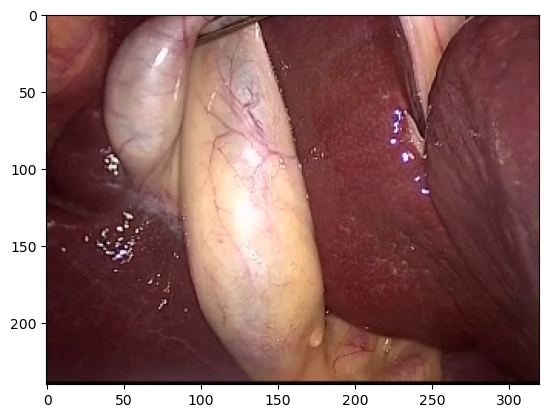

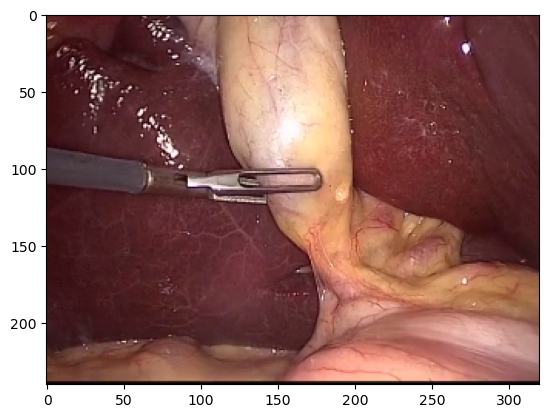

5


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kornia import image_to_tensor

prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_frames"
df = pd.read_pickle(f"{prefix}/pre_processed_log_test_train.pkl")

idx0 = 10
idcs = np.arange(idx0, idx0+5)*20
imgs = []


for idx in idcs:
    img = np.load(f"{prefix}/{df.iloc[idx].folder}/{df.iloc[idx].file}")
    img = cv2.resize(img, [320, 240])
    imgs.append(img)

plt.imshow(imgs[0])
plt.show()
plt.imshow(imgs[-1])
plt.show()

device = "cuda"

imgsT = []
for img in imgs:
    imgsT.append(image_to_tensor(img, False).to(device).float()/255.)

print(len(imgsT))

# Deep Homography Estimation

In [2]:
from endoscopy.homography_estimator import HomographyEstimator, MODEL
estimator = HomographyEstimator(MODEL.HOMOGRAPHY_ESTIMATION.H_64_RESNET_34, device=device)

/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/torch/serialization.py:602: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


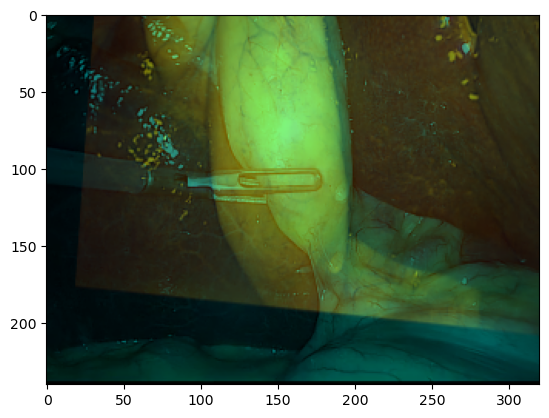

In [3]:
import torch
from endoscopy.utils import yt_alpha_blend
from kornia.geometry import warp_perspective
from kornia import tensor_to_image

H = torch.eye(3).to(device).unsqueeze(0)

for i in range(len(imgsT)-1):
    Hi, duv = estimator(imgsT[i], imgsT[i+1])
    H = torch.matmul(Hi, H)

wrp = warp_perspective(imgsT[0], H.inverse(), imgsT[-1].shape[-2:])

blendT = yt_alpha_blend(
    imgsT[-1],
    wrp
)
plt.imshow((tensor_to_image(blendT, False)*255).astype(int))

# Deep Keypoint

In [4]:
import kornia
loftr = kornia.feature.LoFTR().to(device)
ransac = kornia.geometry.RANSAC(inl_th=1.0).to(device)

/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/kornia/feature/loftr/utils/coarse_matching.py:243: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mkpts0_c = torch.stack([i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]], dim=1) * scale0
/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/kornia/feature/loftr/utils/coarse_matching.py:244: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='t

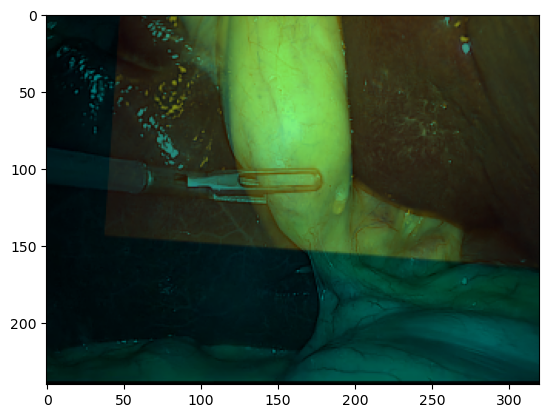

In [5]:
import matplotlib.pyplot as plt
from kornia.geometry import warp_perspective
from endoscopy.utils import yt_alpha_blend
from kornia import tensor_to_image

input = {"image0": kornia.color.rgb_to_grayscale(imgsT[0]), "image1": kornia.color.rgb_to_grayscale(imgsT[-1])}
correspondence_dict = loftr(input)
H, mask = ransac(correspondence_dict["keypoints0"], correspondence_dict["keypoints1"])

wrp = warp_perspective(imgsT[0], H.unsqueeze(0), imgsT[-1].shape[-2:])
blendT = yt_alpha_blend(
    imgsT[-1],
    wrp
)
plt.imshow((tensor_to_image(blendT, False)*255).astype(int))


In [6]:
import sys
sys.path.append("..")
from utils.processing import LoFTRHomographyEstimation

loftr_estimator = LoFTRHomographyEstimation()
loftr_estimator.to(device)
duv = loftr_estimator(imgsT[0], imgsT[-1])
print(duv)

/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/kornia/feature/loftr/utils/coarse_matching.py:243: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mkpts0_c = torch.stack([i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]], dim=1) * scale0
/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/kornia/feature/loftr/utils/coarse_matching.py:244: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='t

torch.Size([1, 4, 2])
torch.Size([1, 4, 3])
torch.Size([3, 3])


RuntimeError: self must be a 3D tensor

: 